In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from time import time

## Theta cut 

In [2]:
angle_range_wtheta_1_1 = 20.0
angle_range_wtheta_2_2 = 8.0
angle_range_wtheta_3_3 = 6.0
angle_range_wtheta_4_4 = 4.0
angle_range_wtheta_5_5 = 2.0
theta_cut = np.array([angle_range_wtheta_1_1, angle_range_wtheta_2_2, angle_range_wtheta_3_3, angle_range_wtheta_4_4, angle_range_wtheta_5_5])
theta_cut *= np.pi / 180. / 60.

## Loading DES data

In [3]:
from astropy.io import fits
des = fits.open('../../../EFTofLSS/DES/2pt_NG_mcal_1110.fits')

tam = np.empty(shape=(20)) # angle theta in arcmin
wdes = np.empty(shape=(5*20)) # angular correlation function
for i, line in enumerate(des['wtheta'].data):
    bin1, bin2, angbin, val, ang, npairs = line
    if i < 20: tam[i] = ang
    wdes[i] = val
wdes = wdes.reshape(5, 20)
t = tam * np.pi/(60. * 180.) # angle theta in radians

cov = des['COVMAT'].data[-100:, -100:]
err = np.sqrt(np.diag(cov)).reshape(5,-1)

N = des['nz_lens'].data.shape[0]
zl = np.empty(shape=(N))
nl = np.empty(shape=(5,N))
for i, line in enumerate(des['nz_lens'].data):
    zlow, zmid, zhigh, bin1, bin2, bin3, bin4, bin5 = line
    zl[i] = zmid
    for j in range(5): nl[j,i] = line[3+j]/(zhigh-zlow)
for j in range(5): nl[j] /= np.trapz(nl[j], x=zl)

N = des['nz_source'].data.shape[0]
zs = np.empty(shape=(N))
ns = np.empty(shape=(4,N))
for i, line in enumerate(des['nz_source'].data):
    zlow, zmid, zhigh, bin1, bin2, bin3, bin4 = line
    zs[i] = zmid
    for j in range(4): ns[j,i] = line[3+j]/(zhigh-zlow)
for j in range(4): ns[j] /= np.trapz(ns[j], x=zs)
    
zz = zl[zl<2.]
zz = zz[1:]
nlens = interp1d(zl, nl, kind='cubic', axis=-1)(zz)
nsource = interp1d(zs, ns, kind='cubic', axis=-1)(zz)

## DESY1 relative error

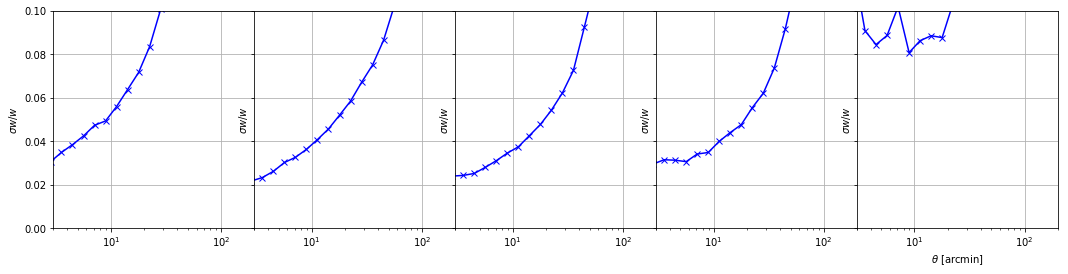

In [4]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=True)
for i in range(5):
    # axs[i].plot(tam, err[i]/abs(wdes[i])/t**.5/100., 'b-', marker='x')
    axs[i].plot(tam, err[i]/abs(wdes[i]), 'b-', marker='x')
    axs[i].set_ylim(0., .1)
    axs[i].grid()
    axs[i].set_xticks(np.arange(3, 31, 1.0))
    axs[i].set_ylabel(r'$\sigma w / w$ ')
plt.xlabel(r'$\theta$ [arcmin]')
plt.xlim(3,200)
plt.xscale('log')
plt.subplots_adjust(wspace=0, hspace=0)

we choose relerr = 2e-1 * t**0.5

## DESY1 absolute w

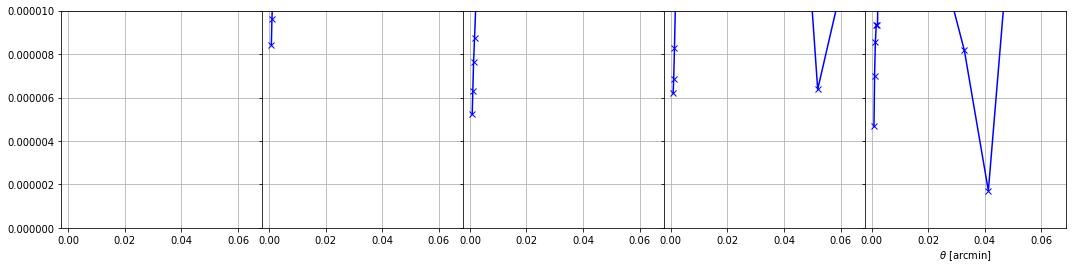

In [5]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=True)
for i, ylim in enumerate([8,3,1.8, 1.2, 1]): 
    axs[i].plot(t, t**1.5*abs(wdes[i]), 'b-', marker='x')
    axs[i].set_ylim(0., 1e-5)
    axs[i].grid()
plt.xlabel(r'$\theta$ [arcmin]')
plt.subplots_adjust(wspace=0, hspace=0)

we choose abserr = 5e-6 * theta^-1.5 (cuba)

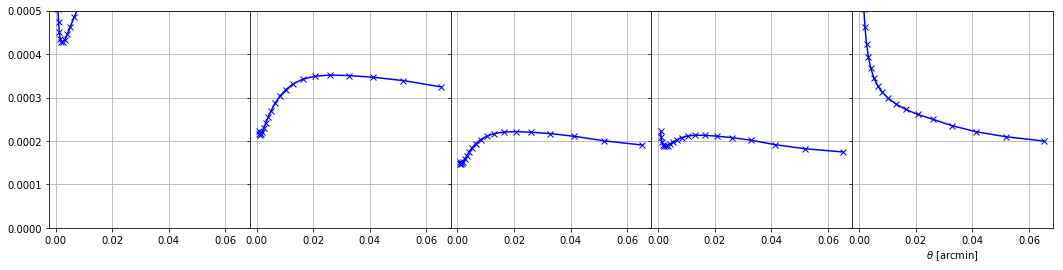

In [6]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=True)
for i, ylim in enumerate([8,3,1.8, 1.2, 1]): 
    axs[i].plot(t, t**0.5*abs(err[i]), 'b-', marker='x')
    # axs[i].plot(t, abs(err[i]), 'b-', marker='x')
    axs[i].set_ylim(0., 5e-4)
    axs[i].grid()
plt.xlabel(r'$\theta$ [arcmin]')
plt.subplots_adjust(wspace=0, hspace=0)

we choose abserr = 1e-4 * theta^-0.5 (cuba)

## Pybird clustering

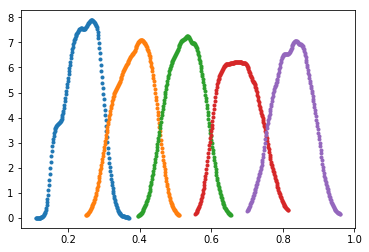

In [23]:
Nbin = 5
zeff = np.array([0.24, 0.38, 0.525, 0.685, 0.83])
Nz = 200

zp = np.empty(shape=(Nbin, Nz))
nz = np.empty(shape=(Nbin, Nz))

for i in range(Nbin):
    zp[i] = np.linspace(zeff[i]-0.13, zeff[i]+0.13, Nz) 
    #zp[i] = np.array([zeff[i]-sz+di for di in dz])
    nz[i] = interp1d(zz, nlens[i], kind='cubic')(zp[i])
    plt.plot(zp[i], nz[i], '.')

In [8]:
import pybird
from importlib import reload
reload(pybird)
h = 0.9 # 0.6736
cosmo = {'ln10^{10}A_s': 3.044, 'n_s': 0.96, 'h': h, 'omega_b': 0.02237, 'omega_cdm': 0.120}

In [9]:
correlator = pybird.Correlator()

correlator.set({
    'output': 'w',
    'skycut': 5,
    'z': zeff,
    'zz': zp,
    'nz': nz,
    'xdata': t,
    'with_resum': False,
    'w_integrator': 'trapz'
})

t0 = time()
correlator.compute(cosmo, module='class')
print (time()-t0)

21.156394004821777


In [10]:
correlator2 = pybird.Correlator()

correlator2.set({
    'output': 'w',
    'skycut': 5,
    'z': zeff,
    'zz': zp,
    'nz': nz,
    'xdata': t,
    'with_resum': False,
    'w_integrator': 'cuba'
})
t0 = time()
correlator2.compute(cosmo, module='class')
print (time()-t0)

71.40045094490051


In [11]:
#DES bestfit on Planck cosmo
allb1 = np.array([1.54723378, 1.75451502, 1.58463946, 2.06286812, 2.12105789])
allc2 = np.array([1.13796165, 1.03736484, 0.44588897, 1.23730009, 1.35915396])
allb3 = np.array([4.11719058,  2.76264961,  2.78083871, 2.07136121,  0.52023055])
allcct = np.array([0.57078733, -0.20319326, -0.47681262, 0.03664512, 0.33028463])

def bias_array_to_dict(b1, c2, b3, cct): return {"b1": b1, "b2": c2/np.sqrt(2.), "b3": b3, "b4": c2/np.sqrt(2.), "cct": cct}
bias =  np.array([bias_array_to_dict(b1, c2, b3, cct) for b1, c2, b3, cct in zip(allb1, allc2, allb3, allcct)])

wtrapz = correlator.get(bias)
wcuba = correlator2.get(bias)

## linear

trapz vs cuba

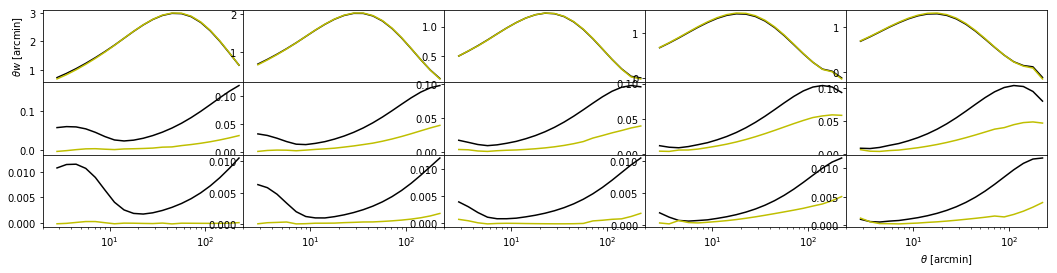

In [210]:
fig, axs = plt.subplots(correlator.co.N11, 5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    for j in range(correlator.co.N11):
        axs[j,i].plot(tam, tam*correlator.birds[i].b11[j]*correlator.birds[i].wlin[j], 'k', label='trapz')
        axs[j,i].plot(tam, tam*correlator2.birds[i].b11[j]*correlator2.birds[i].wlin[j], 'y', label='cuba')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0,0].set_ylabel(r'$\theta w$ [arcmin]')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

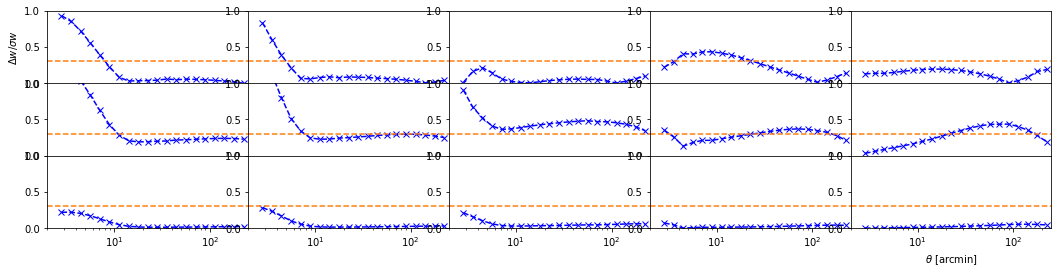

In [211]:
fig, axs = plt.subplots(correlator.co.N11, 5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    for j in range(correlator.co.N11):
        axs[j,i].plot(tam, abs(correlator.birds[i].b11[j]*correlator.birds[i].wlin[j]-correlator2.birds[i].b11[j]*correlator2.birds[i].wlin[j])/err[i], 'bx', ls='--')
        axs[j,i].set_ylim(0, 1.)
        axs[j,i].axhline(0.3, color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0,0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

## loop

 trapz vs cuba

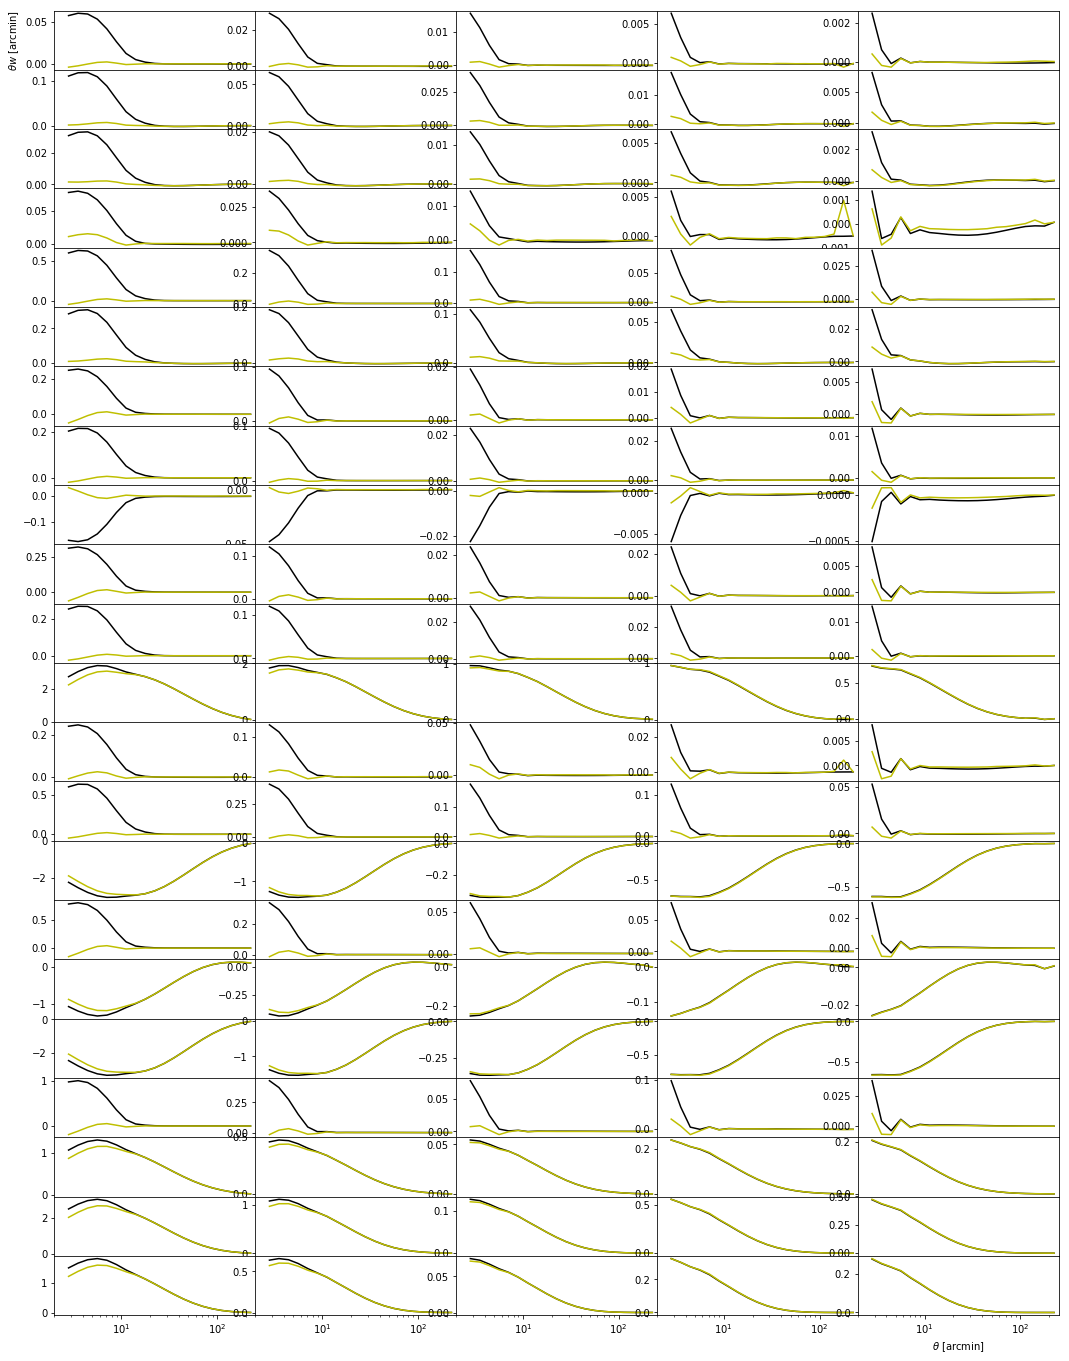

In [212]:
fig, axs = plt.subplots(correlator.co.Nloop, 5, figsize=(18,24), sharex=True, sharey=False)
for i in range(5):
    for j in range(correlator.co.Nloop):
        axs[j,i].plot(tam, tam*correlator.birds[i].bloop[j]*correlator.birds[i].wloop[j], 'k', label='trapz')
        axs[j,i].plot(tam, tam*correlator2.birds[i].bloop[j]*correlator2.birds[i].wloop[j], 'y', label='cuba')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0,0].set_ylabel(r'$\theta w$ [arcmin]')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

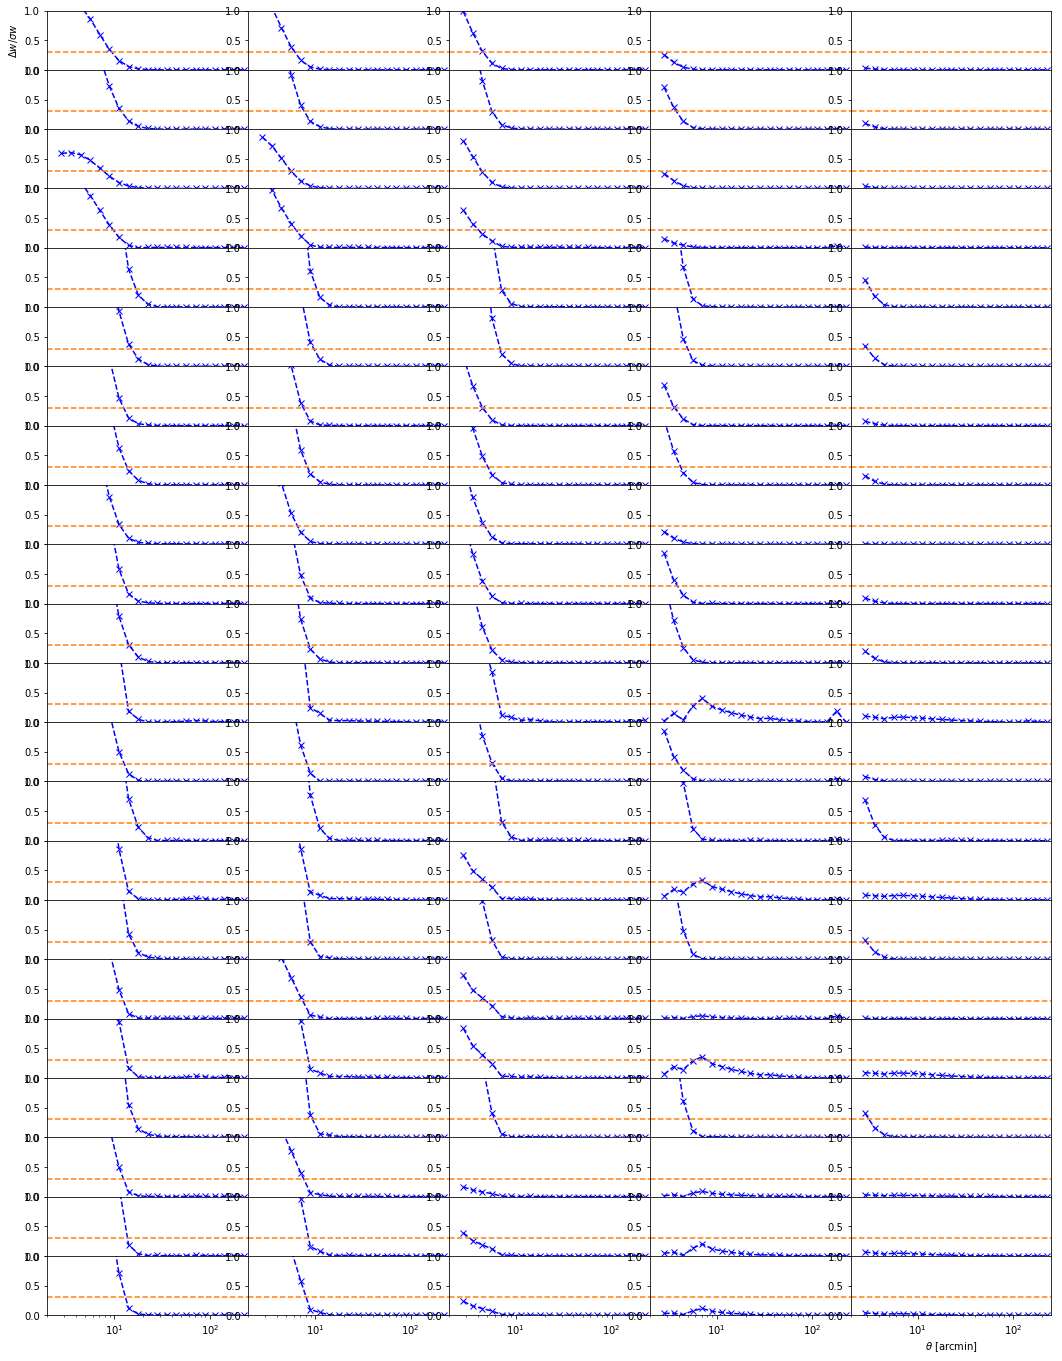

In [213]:
fig, axs = plt.subplots(correlator.co.Nloop, 5, figsize=(18,24), sharex=True, sharey=False)
for i in range(5):
    for j in range(correlator.co.Nloop):
        axs[j,i].plot(tam, abs(correlator.birds[i].bloop[j]*correlator.birds[i].wloop[j]-correlator2.birds[i].bloop[j]*correlator2.birds[i].wloop[j])/err[i], 'bx', ls='--')
        axs[j,i].set_ylim(0, 1.)
        axs[j,i].axhline(0.3, color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0,0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

which loops can be neglected?

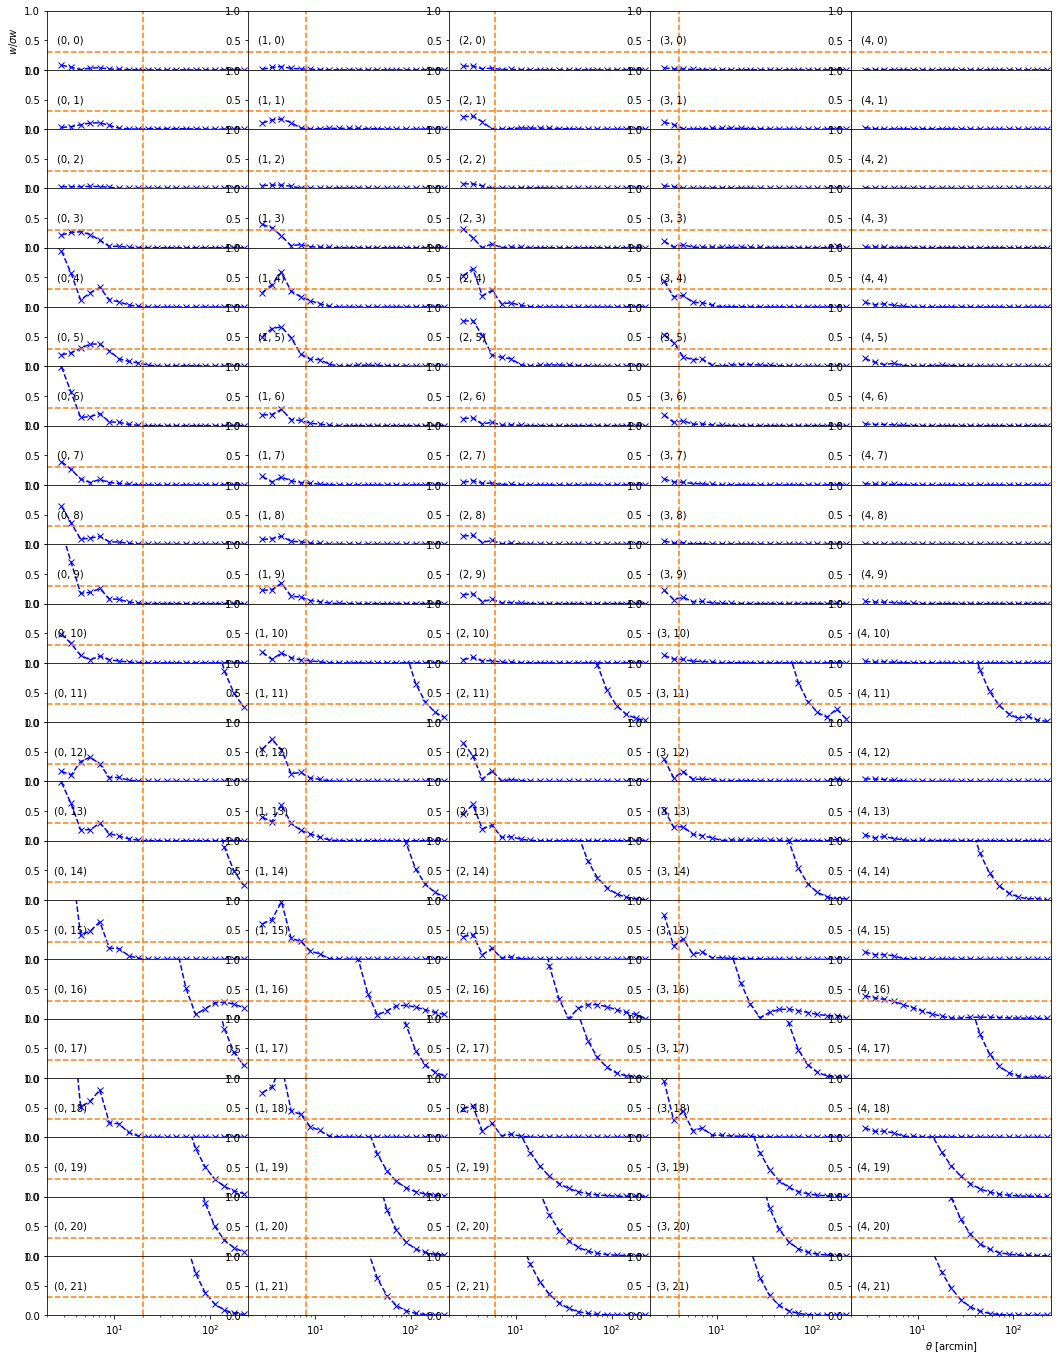

In [214]:
fig, axs = plt.subplots(correlator.co.Nloop, 5, figsize=(18,24), sharex=True, sharey=False)
for i in range(5):
    for j in range(correlator.co.Nloop):
        axs[j,i].plot(tam, abs(correlator2.birds[i].bloop[j]*correlator2.birds[i].wloop[j])/err[i], 'bx', ls='--')
        axs[j,i].set_ylim(0, 1.)
        axs[j,i].axhline(0.3, color='C1', linestyle='--')
        axs[j,i].axvline(theta_cut[i], color='C1', linestyle='--')
        axs[j,i].text(3.5, 0.5, '(%s, %s)' % (i, j), ha='center', va='center')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0,0].set_ylabel(r'$w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

can neglect loop: 0 to 10

## counterterm


trapz vs cuba

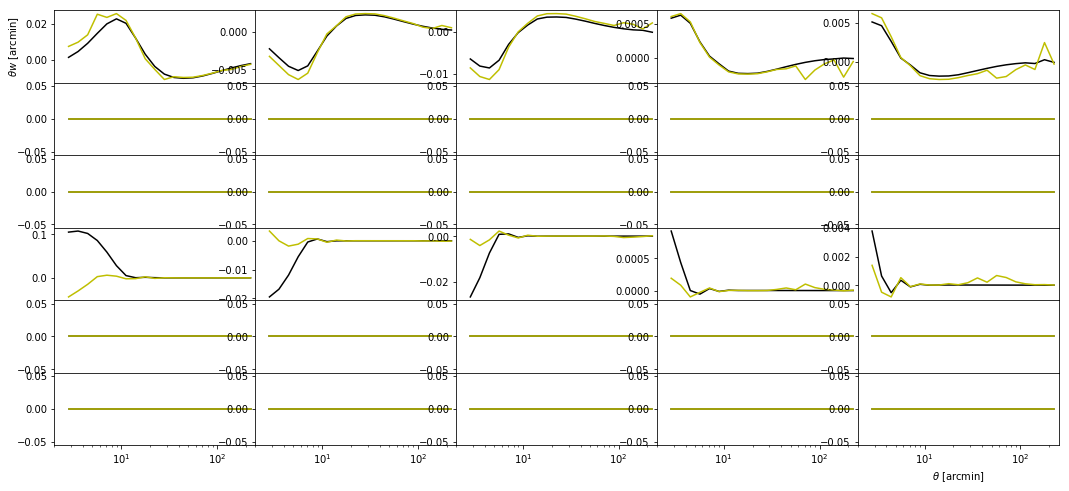

In [215]:
fig, axs = plt.subplots(correlator.co.Nct, 5, figsize=(18,8), sharex=True, sharey=False)
for i in range(5):
    for j in range(correlator.co.Nct):
        axs[j,i].plot(tam, tam*correlator.birds[i].bct[j]*correlator.birds[i].wct[j], 'k', label='trapz')
        axs[j,i].plot(tam, tam*correlator2.birds[i].bct[j]*correlator2.birds[i].wct[j], 'y', label='cuba')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0,0].set_ylabel(r'$\theta w$ [arcmin]')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

which counterterm can be neglected?

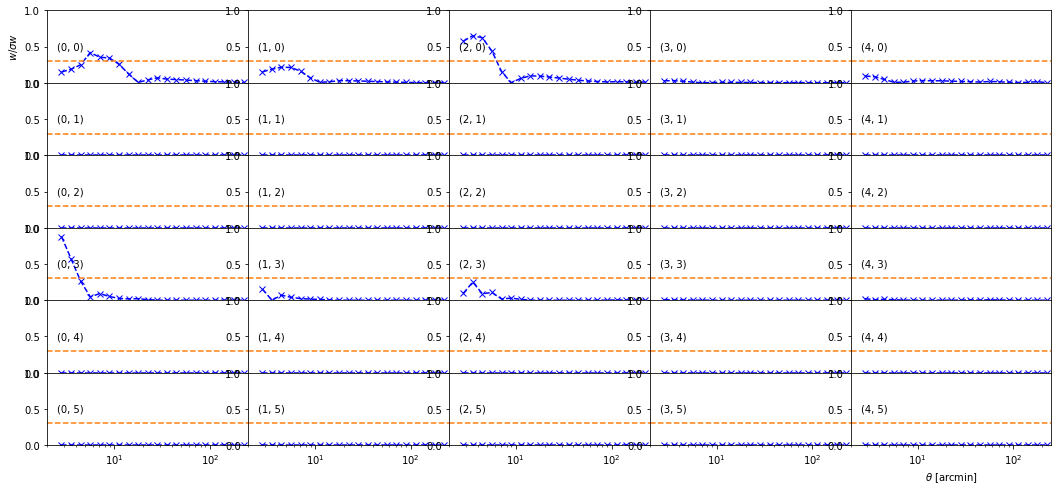

In [216]:
fig, axs = plt.subplots(correlator.co.Nct, 5, figsize=(18,8), sharex=True, sharey=False)
for i in range(5):
    for j in range(correlator.co.Nct):
        axs[j,i].plot(tam, abs(correlator2.birds[i].bct[j]*correlator2.birds[i].wct[j])/err[i], 'bx', ls='--')
        axs[j,i].set_ylim(0, 1.)
        axs[j,i].axhline(0.3, color='C1', linestyle='--')
        axs[j,i].text(3.5, 0.5, '(%s, %s)' % (i, j), ha='center', va='center')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0,0].set_ylabel(r'$ w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

can neglect counterterm: all except 0

##  Full

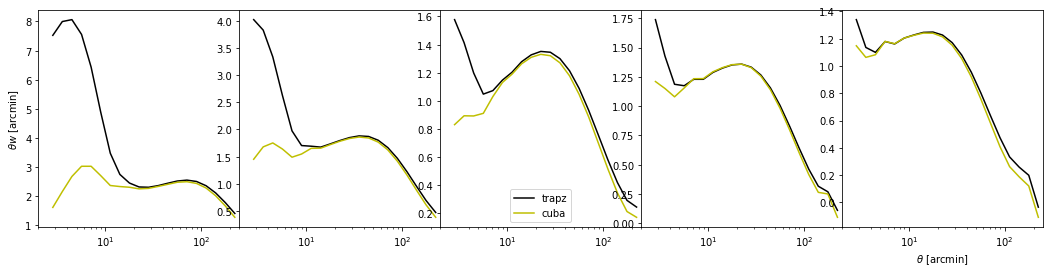

In [217]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    axs[i].plot(tam, tam*wtrapz[i], 'k', label='trapz')
    axs[i].plot(tam, tam*wcuba[i], 'y', label='cuba')

axs[2].legend(loc='lower center')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0].set_ylabel(r'$\theta w$ [arcmin]')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig('w_precision.pdf', bbox_inches='tight')

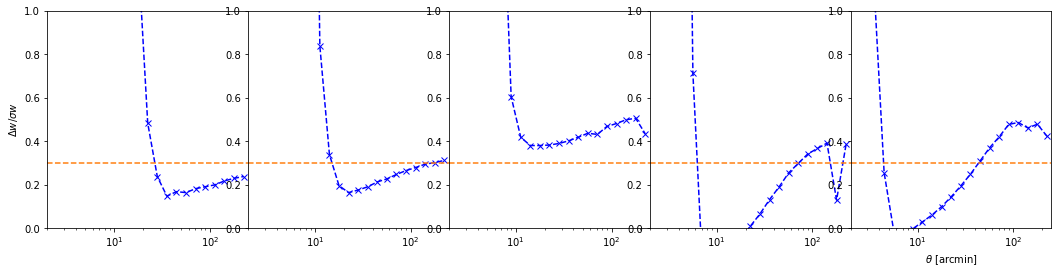

In [218]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    axs[i].plot(tam, (wtrapz[i]-wcuba[i])/err[i], 'bx', ls='--', label='cuba')
    axs[i].set_ylim(0, 1.)
    axs[i].axhline(0.3, color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)

## fast pybird

we neglect some loops and some counterterm, see above

In [302]:
import pybird
from importlib import reload
reload(pybird)

<module 'pybird' from '/Users/pierre/Documents/github/pybird/pybird_dev/pybird.py'>

In [303]:
correlator3 = pybird.Correlator()

correlator3.set({
    'output': 'w',
    'skycut': 5,
    'z': zeff,
    'zz': zp,
    'nz': nz,
    'xdata': t,
    'with_resum': False,
    'w_integrator': 'fast'
})
t0 = time()
correlator3.compute(cosmo, module='class')
print (time()-t0)

AttributeError: 'Angular' object has no attribute 'wfast'

In [221]:
wfast = correlator3.get(bias)

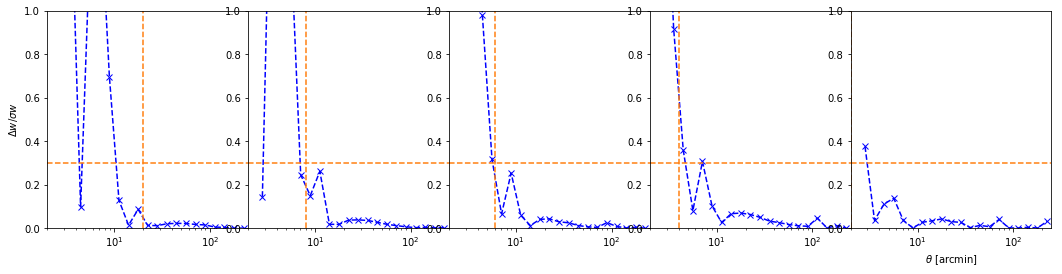

In [222]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    axs[i].plot(tam, abs(wfast[i]-wcuba[i])/err[i], 'bx', ls='--', label='cuba')
    axs[i].set_ylim(0, 1.)
    axs[i].axhline(0.3, color='C1', linestyle='--')
    axs[i].axvline(theta_cut[i], color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)

with theta cut

In [14]:
import pybird
from importlib import reload
reload(pybird)

correlator5 = pybird.Correlator()

correlator5.set({
    'output': 'w',
    'skycut': 5,
    'z': zeff,
    'zz': zp,
    'nz': nz,
    'xdata': t,
    'with_resum': False,
    'w_integrator': 'cuba',
    'w_theta_cut': theta_cut
})
t0 = time()
correlator5.compute(cosmo, module='class')
print (time()-t0)

wprecision = correlator5.get(bias)

233.3028793334961


In [21]:
import pybird
from importlib import reload
reload(pybird)

correlator5 = pybird.Correlator()

correlator5.set({
    'output': 'w',
    'skycut': 5,
    'z': zeff,
    'zz': zp,
    'nz': nz,
    'xdata': t,
    'with_resum': False,
    'w_integrator': 'cuba',
    'w_theta_cut': theta_cut
})
t0 = time()
correlator5.compute(cosmo, module='class')
print (time()-t0)

wprecision2 = correlator5.get(bias)

132.68572616577148


In [15]:
import pybird
from importlib import reload
reload(pybird)

correlator4 = pybird.Correlator()

correlator4.set({
    'output': 'w',
    'skycut': 5,
    'z': zeff,
    'zz': zp,
    'nz': nz,
    'xdata': t,
    'with_resum': False,
    'w_integrator': 'cuba',
    'w_theta_cut': theta_cut
})
t0 = time()
correlator4.compute(cosmo, module='class')
print (time()-t0)
wfaster = correlator4.get(bias)

37.58053398132324


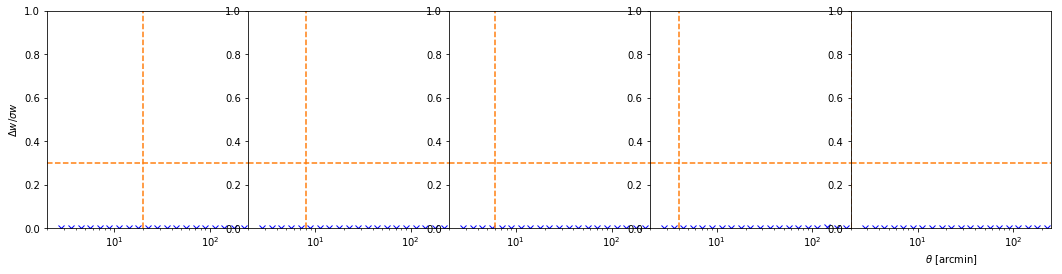

In [22]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    axs[i].plot(tam, abs(wfaster[i]-wprecision2[i])/err[i], 'bx', label='cuba')
    axs[i].set_ylim(0, 1.)
    axs[i].axhline(0.3, color='C1', linestyle='--')
    axs[i].axvline(theta_cut[i]*180*60/np.pi, color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)

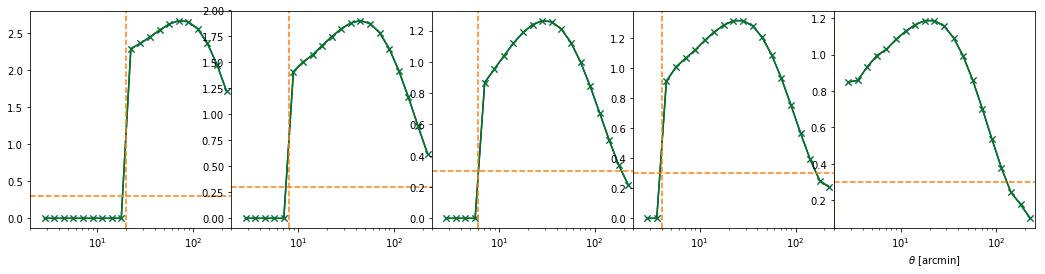

In [20]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    axs[i].plot(tam, tam*wfaster[i], 'bx', ls='-', label='cuba')
    axs[i].plot(tam, tam*wprecision[i], 'gx', ls='-', label='cuba')
    #axs[i].set_ylim(0, 1.)
    axs[i].axhline(0.3, color='C1', linestyle='--')
    axs[i].axvline(theta_cut[i]*180*60/np.pi, color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
#axs[0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)

In [12]:
import pybird
from importlib import reload
reload(pybird)

correlator6 = pybird.Correlator()

correlator6.set({
    'output': 'w',
    'skycut': 5,
    'z': zeff,
    'zz': zp,
    'nz': nz,
    'xdata': t,
    'with_resum': False,
    'w_integrator': 'cuba',
    'w_theta_cut': theta_cut
})
t0 = time()
correlator6.compute(cosmo, module='class')
print (time()-t0)
werr = correlator6.get(bias)

24.671013832092285


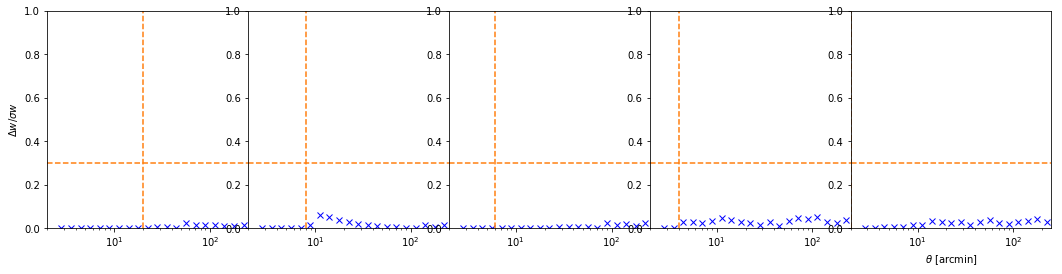

In [13]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    axs[i].plot(tam, abs(werr[i])/err[i], 'bx', label='cuba')
    axs[i].set_ylim(0, 1.)
    axs[i].axhline(0.3, color='C1', linestyle='--')
    axs[i].axvline(theta_cut[i]*180*60/np.pi, color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)

## Comparison to Limber

In [227]:
from limber import Limber
limber = Limber(t, zz, nlens, nsource, load=False, save=False)

In [228]:
from classy import Class
M = Class()
M.set({'output': 'mPk', 'z_max_pk': 2., 'P_k_max_1/Mpc': 2., 'non linear': 'halofit'})
M.set(cosmo)
M.compute()

zfid = 0.4
kk = np.geomspace(1.5e-5, 1., 200)

# for Limber
pk = np.array([M.pk_lin(ki, zfid) for ki in kk]) # linear P(k) in (Mpc)**3
pnl = np.array([M.pk(ki, zfid) for ki in kk]) # halofit Pnl(k) in (Mpc)**3
def deriv(x, func, dx=0.001): return 0.5*(func(x+dx)-func(x-dx))/dx
def comoving_distance(z): return M.angular_distance(z)*(1+z)
rz = np.array([comoving_distance(z) for z in zz])
dr_by_dz = np.array([deriv(z, comoving_distance) for z in zz])
dz_by_dr = 1/dr_by_dz
Dz = np.array([M.scale_independent_growth_factor(zi) for zi in zz])
Dfid = M.scale_independent_growth_factor(zfid)
h = M.h()
Omega0_m = M.Omega0_m()

In [229]:
zz[:100]

array([0.0151, 0.0251, 0.0351, 0.0451, 0.0551, 0.0651, 0.0751, 0.0851,
       0.0951, 0.1051, 0.1151, 0.1251, 0.1351, 0.1451, 0.1551, 0.1651,
       0.1751, 0.1851, 0.1951, 0.2051, 0.2151, 0.2251, 0.2351, 0.2451,
       0.2551, 0.2651, 0.2751, 0.2851, 0.2951, 0.3051, 0.3151, 0.3251,
       0.3351, 0.3451, 0.3551, 0.3651, 0.3751, 0.3851, 0.3951, 0.4051,
       0.4151, 0.4251, 0.4351, 0.4451, 0.4551, 0.4651, 0.4751, 0.4851,
       0.4951, 0.5051, 0.5151, 0.5251, 0.5351, 0.5451, 0.5551, 0.5651,
       0.5751, 0.5851, 0.5951, 0.6051, 0.6151, 0.6251, 0.6351, 0.6451,
       0.6551, 0.6651, 0.6751, 0.6851, 0.6951, 0.7051, 0.7151, 0.7251,
       0.7351, 0.7451, 0.7551, 0.7651, 0.7751, 0.7851, 0.7951, 0.8051,
       0.8151, 0.8251, 0.8351, 0.8451, 0.8551, 0.8651, 0.8751, 0.8851,
       0.8951, 0.9051, 0.9151, 0.9251, 0.9351, 0.9451, 0.9551, 0.9651,
       0.9751, 0.9851, 0.9951, 1.0051])

In [230]:
limber.computeXi(kk, pk, pnl, rz, dz_by_dr, Dz, Dfid, h, Omega0_m, A=0, alpha=0)

In [231]:
def bias_for_limber(bval, bg=None): # bval: b1, c2, b3 ; bg: Gaussian parameters
        return format_bias(bval, bg)

def format_bias(bval, bg=None):
    if bg is None: bg = bval[2*limber.Ngg:] # starting after (b1, c2)_i, i=1, ..., Ngg
    bgg = np.vstack([[bval[i] for i in range(limber.Ngg)], 
                     [bval[i]/np.sqrt(2) for i in np.arange(limber.Ngg, 2*limber.Ngg)], 
                     [bg[i] for i in np.arange(limber.Nbin, limber.Nbin+limber.Ngg)], 
                     [bval[i]/np.sqrt(2) for i in np.arange(limber.Ngg, 2*limber.Ngg)]])
    cgg = np.array([bg[i] for i in np.arange(2*limber.Nss+limber.Ngs, limber.Nbin)])
    cgs = np.array([bg[i] for i in np.arange(2*limber.Nss, 2*limber.Nss+limber.Ngs)])
    cssp = np.array([bg[i] for i in range(limber.Nss)])
    cssm = np.array([bg[i] for i in np.arange(limber.Nss, 2*limber.Nss)])
    return bgg, cgg, cgs, cssp, cssm

In [232]:
bval = np.concatenate([allb1, allc2, np.zeros(shape=(2*limber.Nss+limber.Ngs)), allcct, allb3])

In [233]:
limber.setBias(bias_for_limber(bval))

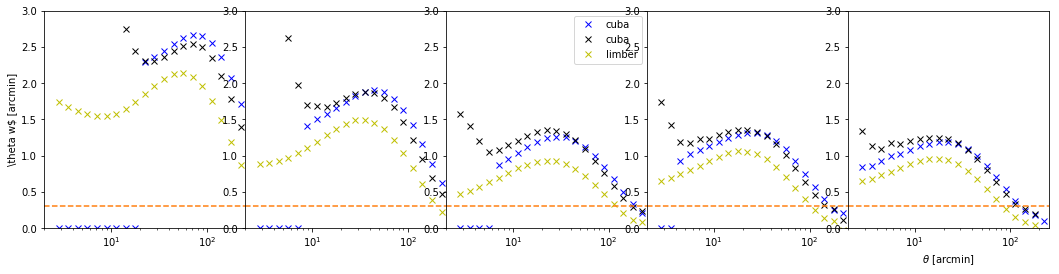

In [350]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    # axs[i].plot(tam, abs(wcuba[i]-limber.Xgg[i])/err[i], 'bx', label='cuba')
    axs[i].plot(tam, tam*wprecision[i], 'bx', label='cuba')
    axs[i].plot(tam, tam*wtrapz[i], 'kx', label='cuba')
    axs[i].plot(tam, tam*limber.Xgg[i], 'yx', label='limber')
    axs[i].set_ylim(0, 3.)
    axs[i].axhline(0.3, color='C1', linestyle='--')
    axs[i].axvline(theta_cut[i], color='C1', linestyle='--')

axs[2].legend()
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0].set_ylabel(r'\theta w$ [arcmin]')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)

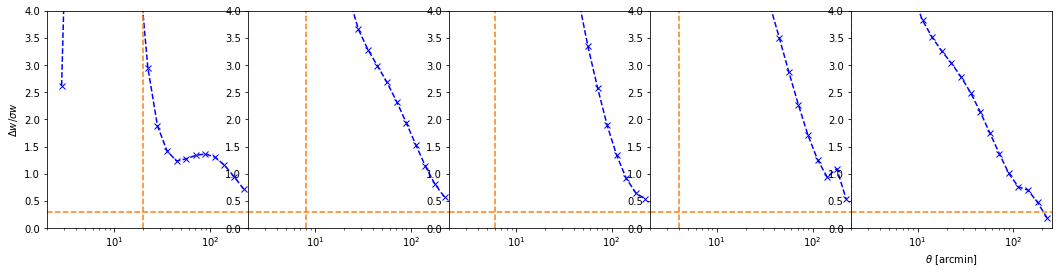

In [235]:
fig, axs = plt.subplots(1,5, figsize=(18,4), sharex=True, sharey=False)
for i in range(5):
    axs[i].plot(tam, abs(wcuba[i]-limber.Xgg[i])/err[i], 'bx', linestyle='--', label='cuba')
    axs[i].set_ylim(0, 4.)
    axs[i].axhline(0.3, color='C1', linestyle='--')
    axs[i].axvline(theta_cut[i], color='C1', linestyle='--')
plt.xscale('log')
plt.xlabel(r'$\theta$ [arcmin]')
axs[0].set_ylabel(r'$\Delta w/\sigma w$')
plt.xlim(2,250)
plt.subplots_adjust(wspace=0, hspace=0)